In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Finite element method (FEM) in 1d
Solve the following 1d diffusion boundary value problem using linear finite elements and compare with analytical solution.

In [2]:
# boundary value problem
#   -k1*u1''(x)=f   in (0,M)
#   -k2*u2''(x)=f   in (M,L)
#   u1(0)=U
#   -k2*u2'(L)=T
#   u1(M)=u2(M)
#   k1*u1'(M+)=k2*u2'(M-)

k1 = 1
k2 = 2
f = -0.1
L = 1
M = 0.5
U = 0
T = 0

Preparation of the discretization and material inputs (similar structure will be used in 2d FEM):

In [3]:
# Discretization
N = 10  # number of intervals
NODES = np.linspace(0, L, N + 1)  # all points
n_NODES = NODES.size  # number of nodes
ELEMENTS = np.column_stack((np.arange(n_NODES - 1), np.arange(1, n_NODES)))  # element indices
n_ELEMENTS = ELEMENTS.shape[0]  # number of elements

# Boundary conditions
DBOUNDARY = [0]  # Dirichlet boundary nodes (index 0 in Python)
DVALUE = [U]  # Dirichlet values
FREENODE = np.ones(n_NODES, dtype=bool)
FREENODE[DBOUNDARY] = False  # Free nodes without Dirichlet boundary
NBOUNDARY = [n_NODES - 1]  # Neumann boundary nodes (last index in Python)
NVALUE = [T]  # Neumann values

# Element properties
LENGTHS = NODES[ELEMENTS[:, 1]] - NODES[ELEMENTS[:, 0]]  # element lengths
MATERIALS = np.full(n_ELEMENTS, k1)  # material properties
CENTERS = np.sum(NODES[ELEMENTS], axis=1) / 2  # element centers
MATERIALS[CENTERS > M] = k2
F = np.full(n_ELEMENTS, f)  # source function values


In [4]:
print(MATERIALS)

[1 1 1 1 1 2 2 2 2 2]


Construct FEM matrix and right hand side vector using local matrices and vectors:

In [5]:
# Local matrix and rhs
A_local = np.array([[1, -1], [-1, 1]])  # Local stiffness matrix
b_local = np.array([1/2, 1/2])  # Local right-hand side vector

# Global matrix and rhs
A = np.zeros((n_NODES, n_NODES))
b = np.zeros(n_NODES)
for i in range(n_ELEMENTS):
    A[np.ix_(ELEMENTS[i], ELEMENTS[i])] += A_local * MATERIALS[i] / LENGTHS[i]
    b[ELEMENTS[i]] += b_local * F[i] * LENGTHS[i]


Eliminate unknowns corresponding to Dirichlet nodes, modify the r. h. s. vector according to Neumann boundary conditions, and solve the resulting linear system:

In [6]:
# Apply boundary conditions
u = np.zeros(n_NODES)
u[~FREENODE] = DVALUE
b -= A @ u
b[NBOUNDARY] -= NVALUE
u[FREENODE] = np.linalg.solve(A[np.ix_(FREENODE, FREENODE)], b[FREENODE])

It remains to plot the solution and compare to analytical solution:

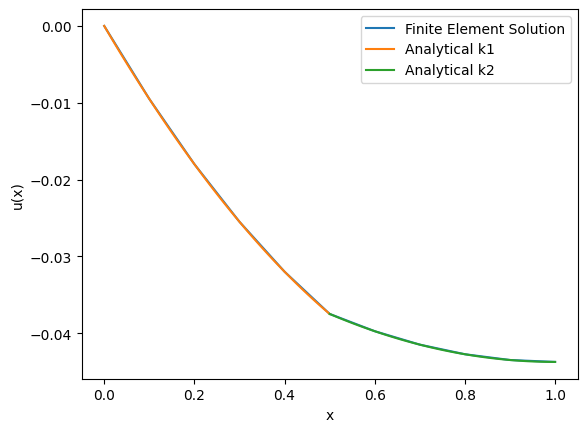

In [7]:
# Analytical solution
C2 = U
D1 = (f * L - T) / k2
C1 = D1 * k2 / k1
D2 = -f / (2 * k1) * M**2 + C1 * M + C2 + f / (2 * k2) * M**2 - D1 * M

def u1(x):
    return -f / (2 * k1) * x**2 + C1 * x + C2

def u2(x):
    return -f / (2 * k2) * x**2 + D1 * x + D2

x1 = np.linspace(0, M, 100)
x2 = np.linspace(M, L, 100)

# Plot the solution
plt.figure()
plt.plot(NODES, u, label='Finite Element Solution')
plt.plot(x1, u1(x1), label='Analytical k1')
plt.plot(x2, u2(x2), label='Analytical k2')
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.show()


## Other tasks:
1) Can we use a discretization that does not have a node in the point of the interface?